In [1]:
from __future__ import print_function

import numpy as np
import os
import argparse
from collections import OrderedDict
import cPickle as pickle

def loadYear(year):
  filename = 'trained_vectors/vectors-{}-ngram.txt'.format(year)
  mapping = OrderedDict()
  with open(filename, 'r') as f:
    for line in f:
      row = line.strip().split()
      w = row[0]
      v = [float(x) for x in row[1:]]
      mapping[w] = v
  return mapping


Load the pre-trained vectors

In [2]:
years = [1900, 1950, 2000]

models = OrderedDict()
for year in years:
    models[year] = loadYear(year)
    print("year {}: {} tokens".format(year, len(models[year])))


year 1900: 33467 tokens
year 1950: 29038 tokens
year 2000: 48452 tokens


Extract a commom set of tokens. We will compare the shift of language using the set of common
tokens. Pairwise inner product (PIP) matrices will be constructed that captures the meanings
of the tokens.

In [3]:
tokens = models[years[0]].keys()
# extract common vocab from two embeddings
for year in years:
    tokens_tmp = models[year].keys()
    tokens = list(set(tokens).intersection(tokens_tmp))
subsample = len(tokens)
if subsample:
  tokens = np.random.choice(tokens, size = subsample, replace=False)
print(len(tokens))


24362


In [4]:
paired_embeds = {}
for token in tokens:
    paired_embeds[token] = []
    for year in years:
        paired_embeds[token].append(models[year][token])

# del models
print("{} tokens to be compared".format(len(paired_embeds)))
dictionary = {v: k for k, v in enumerate(tokens)}

24362 tokens to be compared


In [5]:
normalize = False
Es = OrderedDict()
for idx, year in enumerate(years):
    Es[year] = []
    for token in tokens:
        Es[year].append(paired_embeds[token][idx])
    Es[year] = np.array(Es[year])
    if normalize:
        Es[year] = Es[year] / np.linalg.norm(Es[year], axis=1)[:,None]

Now, consider the PIP loss between embeddings between different years. Depending on the size, 
we use two solutions. It depends on if the PIP matrices are small enough to fit in memory.

In [9]:
year_number = 2
print(np.linalg.norm((Es[years[year_number]][dictionary['number']])))
initial_pairs = [('man', 'woman')]
#print(np.linalg.norm((Es[years[year_number]][dictionary[initial_pairs[0][0]]] - Es[years[year_number]][dictionary[initial_pairs[0][1]]]) -
#                     (Es[years[year_number]][dictionary[initial_pairs[1][0]]] - Es[years[year_number]][dictionary[initial_pairs[1][1]]])))
epsilon = 6e-0
for pair in initial_pairs:
    relation_vec = Es[years[year_number]][dictionary[pair[0]]] - Es[years[year_number]][dictionary[pair[1]]]
    print(np.linalg.norm(relation_vec))
    analogy = Es[years[year_number]] + np.outer(np.ones(Es[years[year_number]].shape[0]), relation_vec)
    for i in range(len(tokens)):
        if i != dictionary['princess']:
            continue
        diff = np.linalg.norm(np.outer(np.ones(Es[years[year_number]].shape[0]), Es[years[year_number]][i]) - analogy, axis=1)
        # print(diff)
        sorted_index = np.argsort(diff)[:10]
        for j in sorted_index:
            print("{}-{}: {}-{}".format(pair[0], pair[1], tokens[j], tokens[i]))

5.434726761089622
3.81781199617544
man-woman: princess-princess
man-woman: princess-woman
man-woman: princess-lady
man-woman: princess-prince
man-woman: princess-queen
man-woman: princess-widow
man-woman: princess-maid
man-woman: princess-countess
man-woman: princess-mistress
man-woman: princess-girl


Now we visualize the result. 

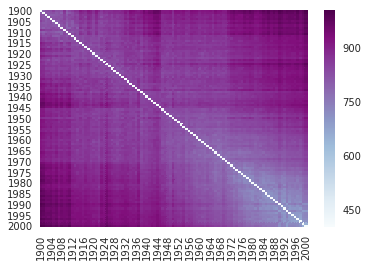

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

np.save('PIP_loss_matrix.npy', PIP_losses)
dimensions = range(PIP_losses.shape[0])
ixgrid = np.ix_(dimensions, dimensions)
real_dimension = years
plt.figure()
df = pd.DataFrame(PIP_losses[ixgrid], index=real_dimension, columns=real_dimension)
ax = sns.heatmap(df, cmap="BuPu", vmin=400)#, xticklabels=len(dimensions)-1, yticklabels=len(dimensions)-1)
fig = ax.get_figure()
fig.savefig("PIP_loss.pdf")
